# Thompson Sampling Notebook

#### *Author: Kunyu He*
#### *University of Chicago, CAPP'20*

In [55]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from collections import Counter
from collections import OrderedDict

### Load Data

Index of the ads are on the column, and each line represents a subject's response to the ads.

In [23]:
ads = pd.read_csv("Ads_CTR_Optimisation.csv")
ads.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


### Data Cleaning

In [24]:
ads.isnull().sum(axis=0)

Ad 1     0
Ad 2     0
Ad 3     0
Ad 4     0
Ad 5     0
Ad 6     0
Ad 7     0
Ad 8     0
Ad 9     0
Ad 10    0
dtype: int64

No value missing.

### A Random Strategy as Benchmark

In [25]:
np.random.seed(123)

N, d = ads.shape
ads_selected = []
total_reward = 0

for n in range(0, N):
    ad = np.random.randint(0, d)
    ads_selected.append(ad)
    total_reward += ads.values[n, ad]

print("Total reward of startegies randomly selected is {}.".format(total_reward))

Total reward of startegies randomly selected is 1229.


In [26]:
counts = dict(Counter(ads_selected))
counts

{2: 1019,
 6: 1004,
 1: 981,
 3: 1005,
 9: 999,
 0: 1027,
 4: 1022,
 7: 986,
 8: 1010,
 5: 947}

We can see that the advertisements are selected equivalently, which is expected.

### UCB from Scratch

In [27]:
def ucb(data):
    """
    """
    N, d = data.shape
    strategies_selected = []
    frequencies_by_strategy = [0] * d
    rewards_by_strategy = [0] * d
    total_reward = 0
    
    for n in range(0, N):
        strategy = 0
        max_upper_bound = 0
        for i in range(0, d):
            if frequencies_by_strategy[i] > 0:
                expected_reward = rewards_by_strategy[i] / frequencies_by_strategy[i]
                margin = math.sqrt(3/2 * math.log(n + 1) / frequencies_by_strategy[i])
                upper_bound = expected_reward + margin
            else:
                upper_bound = 1e400

            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                strategy = i

        strategies_selected.append(strategy)
        frequencies_by_strategy[strategy] += 1
        rewards_by_strategy[strategy] += data.values[n, strategy]
        total_reward += data.values[n, strategy]

    return total_reward, strategies_selected, rewards_by_strategy

In [28]:
total_reward, ads_selected, rewards_by_ad = ucb(ads)
print("Total reward of startegies selected based on UCB is {}.".format(
    total_reward))

Total reward of startegies selected based on UCB is 2178.


The total rewards is lifted by approximately 1000. Frequency of the ads selected.

In [29]:
counts = dict(Counter(ads_selected))
counts

{0: 705,
 1: 387,
 2: 186,
 3: 345,
 4: 6323,
 5: 150,
 6: 292,
 7: 1170,
 8: 256,
 9: 186}

Reward each ad earned.

In [30]:
dict(zip(range(ads.shape[1]), rewards_by_ad))

{0: 120, 1: 47, 2: 7, 3: 38, 4: 1675, 5: 1, 6: 27, 7: 236, 8: 20, 9: 7}

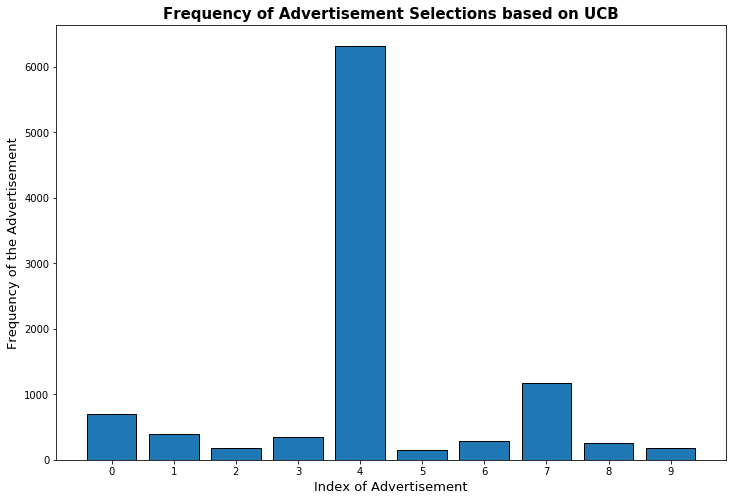

In [31]:
fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(1, 1, 1)

ax.bar(range(ads.shape[1]), counts.values(), edgecolor="black")
ax.set_title("Frequency of Advertisement Selections based on UCB",
             fontdict={'fontsize': 15, 'fontweight': "bold"})
ax.set_xlabel("Index of Advertisement", fontsize=13)
ax.set_ylabel("Frequency of the Advertisement", fontsize=13)
ax.set_xticks(range(ads.shape[1]))

plt.show()

### Thompson Sampling from Scratch

In [45]:
def thompson_sampling(data, seed=123):
    """
    """
    np.random.seed(seed)

    N, d = data.shape
    strategies_selected = []
    reward_count_by_strategy = [0] * d
    nonreward_count_by_strategy = [0] * d
    total_reward = 0

    for n in range(0, N):
        strategy = 0
        max_random = 0
        for i in range(0, d):
            random_beta = np.random.beta(reward_count_by_strategy[i] + 1,
                                         nonreward_count_by_strategy[i] + 1)
            if random_beta > max_random:
                max_random = random_beta
                strategy = i

        strategies_selected.append(strategy)
        reward = data.values[n, strategy]
        if not reward:
            nonreward_count_by_strategy[strategy] += 1
        else:
            reward_count_by_strategy[strategy] += 1
        total_reward += reward

    return total_reward, strategies_selected

In [50]:
total_reward, ads_selected = thompson_sampling(ads)
print("Total reward of startegies selected based on Thompson Samling is {}.".format(total_reward))

Total reward of startegies selected based on Thompson Samling is 2582.


In [66]:
counts = dict(sorted(Counter(ads_selected).items()))
counts

{0: 53, 1: 24, 2: 31, 3: 119, 4: 8902, 5: 34, 6: 47, 7: 686, 8: 68, 9: 36}

Seems Thompson Sampling is finding the dominating strategy and exploit it faster than UBC.

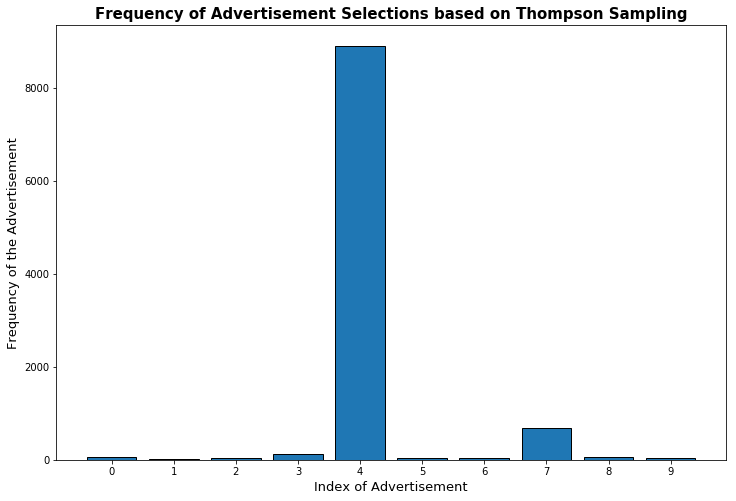

In [67]:
fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(1, 1, 1)

ax.bar(range(ads.shape[1]), counts.values(), edgecolor="black")
ax.set_title("Frequency of Advertisement Selections based on Thompson Sampling",
             fontdict={'fontsize': 15, 'fontweight': "bold"})
ax.set_xlabel("Index of Advertisement", fontsize=13)
ax.set_ylabel("Frequency of the Advertisement", fontsize=13)
ax.set_xticks(range(ads.shape[1]))

plt.show()